<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
# cross validation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# model saving
import pickle

import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Machine learning/churn_analysis/data/churn_data_encoded.csv")
df.head()

,churn_flag,gender_Female,gender_Male,seniorcitizen_No,seniorcitizen_Yes,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,...,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges
0,0.0,True,False,True,False,False,True,True,False,True,...,False,False,True,False,False,True,False,0.000000,0.115423,0.001275
1,0.0,False,True,True,False,True,False,True,False,False,...,False,True,False,False,False,False,True,0.464789,0.385075,0.215867
2,1.0,False,True,True,False,True,False,True,False,False,...,False,False,True,False,False,False,True,0.014085,0.354229,0.010310
3,0.0,False,True,True,False,True,False,True,False,True,...,False,True,False,True,False,False,False,0.619718,0.239303,0.210241
4,1.0,True,False,True,False,True,False,True,False,False,...,False,False,True,False,False,True,False,0.014085,0.521891,0.015330


In [5]:
x = df.drop('churn_flag', axis = 1)
y = df['churn_flag'].values

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

## Model Training

In [6]:
# Grid Search
def get_best_model(estimator, params_grid = {}):
  model = GridSearchCV(estimator = estimator, param_grid = params_grid, cv = 3, scoring = 'accuracy', n_jobs = - 1)
  model.fit(x_train, y_train)
  print('\n--- Best Parameters-----------------------------')
  print(model.best_params_)
  print('\n--- Best Model---------------------------------')
  best_model = model.best_estimator_
  print(best_model)
  return best_model

In [7]:
# model fit function
def model_fit(model, feature_imp = True, cv = 5):

  clf = model.fit(x_train, y_train)

  # prediction
  y_pred = clf.predict(x_test)

  print('\n--- Train Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
  print('\n--- Validation Set -----------------------------')
  print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
  print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
  print('-----------------------------------------------')

  # reports
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm, classes = class_names, title = 'Confusion Matrix')
  print(' ')

  # feature importance
  if feature_imp:
      feat_imp = pd.Series(clf.feature_importances_,index=x_train.columns)
      feat_imp = feat_imp.nlargest(15).sort_values()
      plt.figure()
      plt.title("Most Important Features")
      feat_imp.plot(kind="barh")
      plt.show()



In [10]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
class_names = ['Success','Failure']


## Random Forests


--- Best Parameters-----------------------------
{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

--- Best Model---------------------------------
RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84697 +/- 0.0068
AUC: 0.92201 +/- 0.0043

--- Validation Set -----------------------------
Accuracy: 0.81171 +/- 0.0118
AUC: 0.88462 +/- 0.0056
-----------------------------------------------


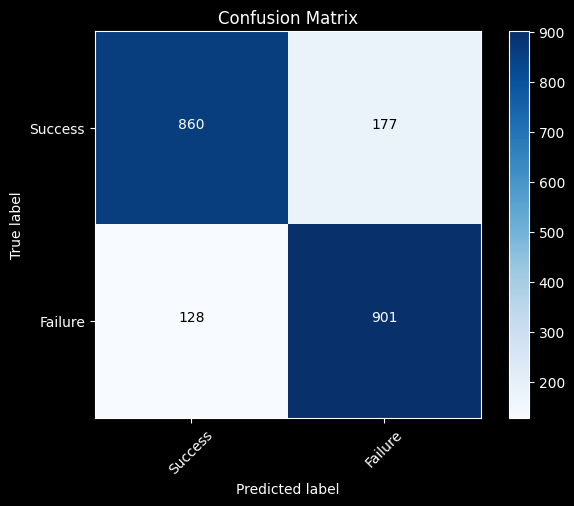

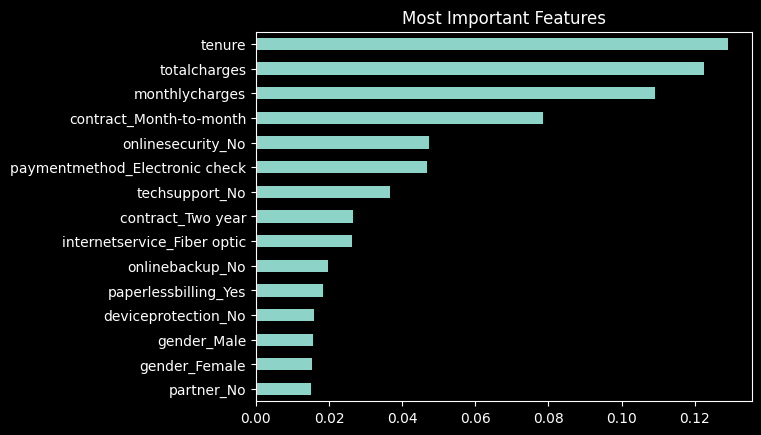

In [14]:
classifier_rf = RandomForestClassifier(random_state = 42)
parameters = {
              'n_estimators': [100, 150, 200],
              'max_depth':[10, 30, 50],
              'max_features': ['sqrt']
              }

clf_rf = get_best_model(classifier_rf, parameters)
model_fit(model = clf_rf, feature_imp = True)

## K-Nearest Neighbors KNN


--- Best Parameters-----------------------------
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

--- Best Model---------------------------------
KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

--- Train Set -----------------------------
Accuracy: 0.81513 +/- 0.0064
AUC: 0.88866 +/- 0.0049

--- Validation Set -----------------------------
Accuracy: 0.77203 +/- 0.0107
AUC: 0.83987 +/- 0.0048
-----------------------------------------------


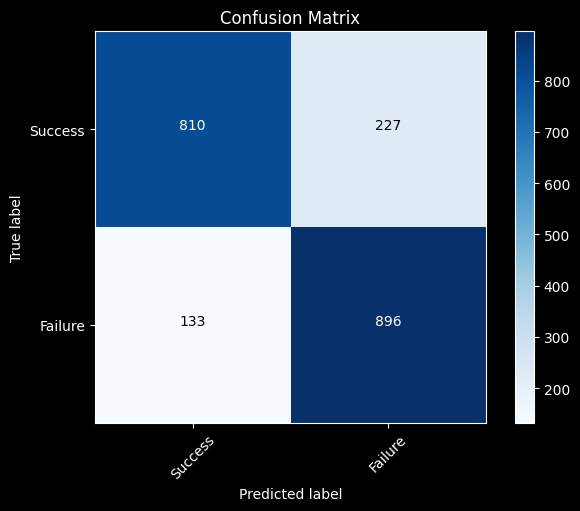

In [15]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [5,6,7],
              'p':[1,2],
              'weights':['uniform', 'distance']}

clf_knn = get_best_model(knn, parameters)
model_fit(model = clf_knn, feature_imp = False)

## Naive Bayes


--- Train Set -----------------------------
Accuracy: 0.74782 +/- 0.0142
AUC: 0.82774 +/- 0.0114

--- Validation Set -----------------------------
Accuracy: 0.74588 +/- 0.0165
AUC: 0.82411 +/- 0.0162
-----------------------------------------------


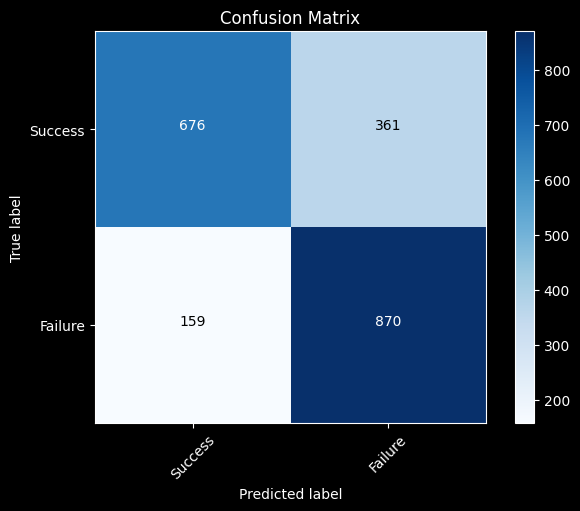

In [16]:
clf_nb = GaussianNB()
model_fit(model = clf_nb, feature_imp = False)

## Logistic Regression


--- Best Parameters-----------------------------
{'penalty': 'l2'}

--- Best Model---------------------------------
LogisticRegression(random_state=42)

--- Train Set -----------------------------
Accuracy: 0.84649 +/- 0.0096
AUC: 0.93210 +/- 0.0046

--- Validation Set -----------------------------
Accuracy: 0.82912 +/- 0.0201
AUC: 0.91496 +/- 0.0110
-----------------------------------------------


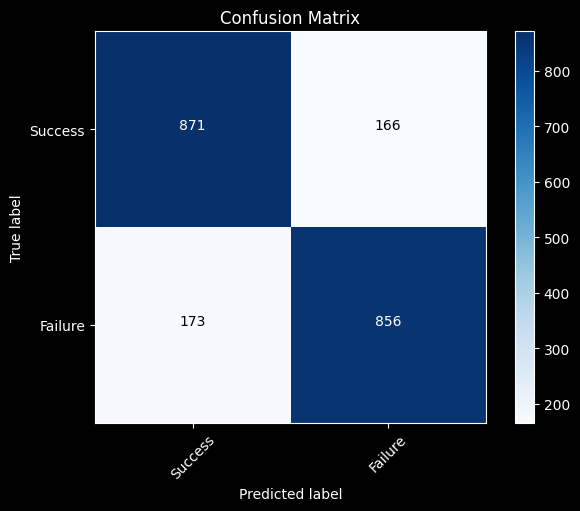

In [17]:
lg = LogisticRegression(random_state=42)
parameters = {
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)


## XGBoost


--- Train Set -----------------------------
Accuracy: 0.84746 +/- 0.0060
AUC: 0.93164 +/- 0.0033

--- Validation Set -----------------------------
Accuracy: 0.81123 +/- 0.0080
AUC: 0.88335 +/- 0.0035
-----------------------------------------------


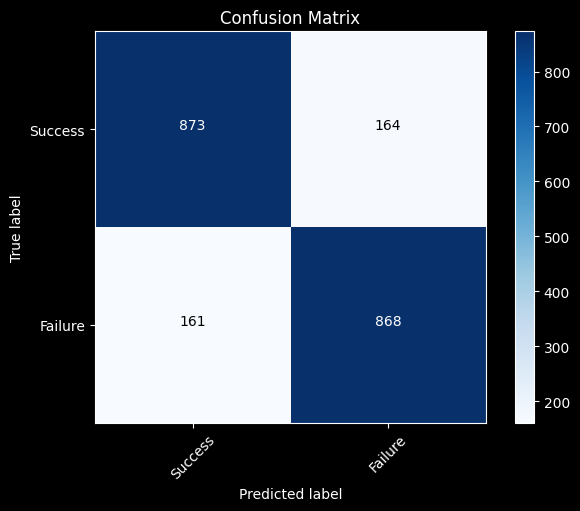

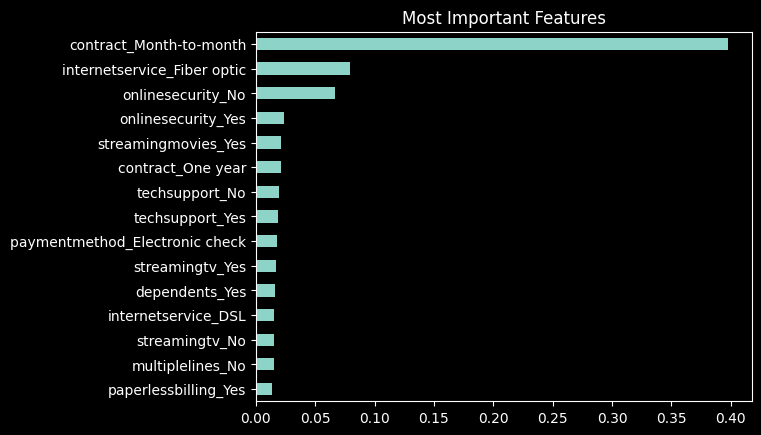

In [18]:
clf_xgb = XGBClassifier(random_state = 42)
model_fit(model = clf_xgb, feature_imp = True)

# Evaluation

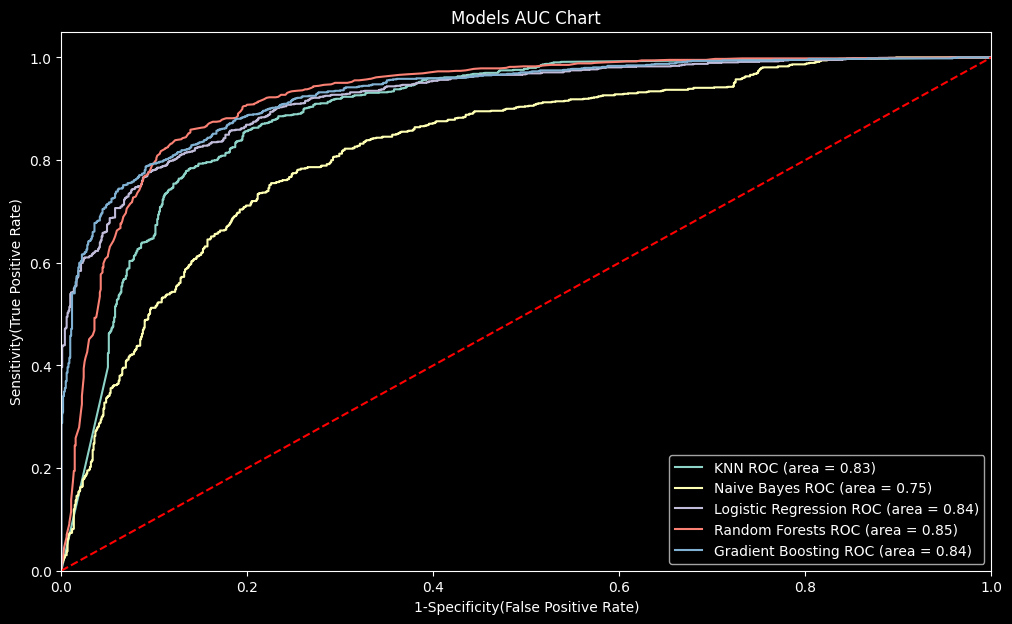

In [19]:
plt.figure(figsize = (12, 7))
models = [
{
    'label': 'KNN',
    'model': clf_knn,
},
{
    'label': 'Naive Bayes',
    'model': clf_nb,
},
{
    'label': 'Logistic Regression',
    'model': clf_lg,
},
{
    'label': 'Random Forests',
    'model': clf_rf,
},
{
    'label': 'Gradient Boosting',
    'model': clf_xgb,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Models AUC Chart')
plt.legend(loc="lower right")
plt.show()   # Display

## K-Fold Cross Validation

In [20]:
# Compare model performance(KFold)
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_xgb]
index =['KNN', 'Naive Bayes', 'Logistic Regression','Random Forests', 'XG Boost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

Logistic Regression    0.829120
Random Forests         0.811710
XG Boost               0.811228
KNN                    0.772026
Naive Bayes            0.745877
dtype: float64

## Selected Model: Random Forests

After careful evaluation and consideration of various factors, I have decided to choose the **Random Forests** model for the following reasons:

1. **Highest Accuracy**: Random Forests achieved the highest accuracy among the models evaluated. Accuracy is a fundamental metric for assessing the overall performance of a classifier, and Random Forests demonstrated superior performance in this aspect.

2. **Effective Avoidance of False Positives/Negatives**: In addition to accuracy, Random Forests also effectively avoided false positives and false negatives. This is crucial, especially in scenarios where misclassifications have significant consequences. Random Forests demonstrated robustness in minimizing both types of errors.

3. **Higher Area Under the Curve (AUC)**: The AUC metric, which represents the area under the Receiver Operating Characteristic (ROC) curve, provides a comprehensive measure of a model's ability to discriminate between classes. Random Forests exhibited a higher AUC, indicating superior discrimination capability compared to other models.

4. **Ensemble Learning Benefits**: Random Forests leverage ensemble learning techniques, which combine multiple decision trees to make predictions. This inherent ensemble nature often leads to improved generalization performance and robustness against overfitting.

By selecting Random Forests as the preferred model, I aim to capitalize on its strengths in accuracy, robustness against misclassifications, discriminative power, and the inherent benefits of ensemble learning. This choice aligns with the goal of maximizing predictive performance while minimizing the risk of erroneous classifications.


In [21]:
filename = '/content/drive/MyDrive/Machine learning/churn_analysis/model.sav'

pickle.dump(clf_rf, open(filename, 'wb'))

In [34]:
feat_imp = pd.DataFrame(clf_rf.feature_importances_, index=x_train.columns, columns=["score"])
feat_imp.reset_index(inplace=True)
feat_imp.rename(columns={"index": "feature"}, inplace=True)
feat_imp.sort_values(by = 'score', ascending = False)

feat_imp.to_csv("/content/drive/MyDrive/Machine learning/churn_analysis/data/feat_imp.csv")